# Initialisation

In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2022-02-17 04:10:19 +01:00)


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 15 ms (started: 2022-02-17 04:10:19 +01:00)


In [3]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Activation,Input,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

#from keras.applications import inceptionV3
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from keras.models import Model, Sequential, load_model
from keras import callbacks


time: 5.92 s (started: 2022-02-17 04:10:22 +01:00)


In [4]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.layer_utils import count_params

%matplotlib inline


time: 16 ms (started: 2022-02-17 04:10:28 +01:00)


# Variables

In [5]:
# seed
random_seed = 42

# resolution des images apres redimmensionnement (/!\ inversé par rapport à scikit)
resol = (240, 320) # (240, 320), [(24 , 32),(48 , 64),(72 , 96)]
# number of class to keep 
family_number = 7 # 7 pour comparaison Xgboost (acc = 0.32) & random 1/7 = 0.14
number_of_images = 5000 # None to get all images 
add_FRUIT360_images = False #add a class with 6000 images of 131 classes of fruit if true (kaggle dataset - 45 random images/class)


# epoch
epochs = 10
# learing rate 
lr = 0.001 # a learning rate of 0.001 is often used / working
# batch size 
batch_size = 32 #32
# base model trainable 
base_model_trainable = True




time: 0 ns (started: 2022-02-17 04:10:28 +01:00)


In [6]:
#Directory path in my com
root_dir ='C:/Users/ANTOINE/Project_Mushroom/' 
raw_data_dir = root_dir + 'raw_data/' #raw images folder
DL_dir = root_dir + 'deep_learning/' #Deep Learning folder
csv_file_paths = 'image_and_json_data.csv'

# export dir with time stamp to save the results of the Deep Learning
timestamp = datetime.datetime.now().strftime('%y%m%d_%HH%M')
export_dir = DL_dir + timestamp + '/'
os.makedirs(export_dir)
print(str(export_dir))

C:/Users/ANTOINE/Project_Mushroom/deep_learning/220217_04H10/
time: 0 ns (started: 2022-02-17 04:10:30 +01:00)


# Dataframe creation and processing

In [7]:
# load final database
df_paths =  pd.read_csv(root_dir + 'image_and_json_data.csv')
print(df_paths.shape)
df_paths.head()

(208774, 38)


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,...,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(243, 320)",ages,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
1,1604.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(320, 164)",ages,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
2,1608.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(320, 286)",ages,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
3,29.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(240, 320)",ages,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
4,680.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(240, 320)",ages,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,...,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,row_data\json\observations_0.json


time: 1.33 s (started: 2022-02-17 04:10:33 +01:00)


In [8]:
# df with path & target 
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths.head()

208774 rows in the file


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,...,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(243, 320)",ages,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
1,1604.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(320, 164)",ages,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
2,1608.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(320, 286)",ages,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
3,29.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(240, 320)",ages,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
4,680.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(240, 320)",ages,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,...,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,row_data\json\observations_0.json


time: 1.31 s (started: 2022-02-17 04:10:34 +01:00)


In [9]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)'] 

time: 47 ms (started: 2022-02-17 04:10:38 +01:00)


In [10]:
# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

time: 47 ms (started: 2022-02-17 04:10:40 +01:00)


In [11]:
# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
df_paths['gbif_info.class'].value_counts()

Agaricomycetes    75164
Name: gbif_info.class, dtype: int64

time: 47 ms (started: 2022-02-17 04:10:41 +01:00)


In [12]:
# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

time: 47 ms (started: 2022-02-17 04:10:44 +01:00)


In [13]:
# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5090
1,Albatrellaceae,200
2,Amanitaceae,4679
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,212
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,39


time: 0 ns (started: 2022-02-17 04:10:47 +01:00)


In [14]:
# keep only top families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:family_number].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

time: 32 ms (started: 2022-02-17 04:10:50 +01:00)


In [15]:
# subset col of interest + label encoding
df = df_paths[['file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,file_path,gbif_info.family,label
5,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
6,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
7,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
8,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
9,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0


time: 31 ms (started: 2022-02-17 04:10:52 +01:00)


In [16]:
df_paths,_ = train_test_split(df_paths,train_size=number_of_images,stratify=df_paths['gbif_info.family'],random_state=random_seed )
print('{} rows in the file'.format(len(df_paths)))

5000 rows in the file
time: 31 ms (started: 2022-02-17 04:10:55 +01:00)


In [17]:
# subset col of interest + label encoding
df = df_paths[['file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,file_path,gbif_info.family,label
123138,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Russulaceae,0
153128,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Russulaceae,0
16589,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Tricholomataceae,1
22151,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,2
110231,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Strophariaceae,3


time: 16 ms (started: 2022-02-17 04:10:57 +01:00)


In [18]:
df

,file_path,gbif_info.family,label
123138,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Russulaceae,0
153128,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Russulaceae,0
16589,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Tricholomataceae,1
22151,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,2
110231,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Strophariaceae,3
...,...,...,...
16711,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,2
136447,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,2
79762,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Strophariaceae,3
126406,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Boletaceae,6


time: 16 ms (started: 2022-02-17 04:11:00 +01:00)


# Data for model

In [19]:
df_train, df_test= train_test_split(df, train_size=0.8, stratify =df['label'], random_state=random_seed)
print(df_train.shape,df_test.shape)

(4000, 3) (1000, 3)
time: 16 ms (started: 2022-02-17 04:11:03 +01:00)


In [20]:
# compute a class weigts dict for unbalanced loss computation
# { cf https://qastack.fr/datascience/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras}
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes =np.unique(df_train['label']),y =df_train['label'])
class_weights = dict(enumerate(class_weights))

time: 0 ns (started: 2022-02-17 04:11:05 +01:00)


In [21]:
# train 
train_data_generator = ImageDataGenerator(
                                          # rotation_range=rotation_range,
                                          # width_shift_range=width_shift_range,
                                          # height_shift_range=height_shift_range,
                                          # shear_range=shear_range,
                                          # zoom_range=zoom_range,
                                          # horizontal_flip=horizontal_flip,
                                          # vertical_flip=vertical_flip
                                          # fill_mode='nearest',
                                        ) 
train_generator = train_data_generator.flow_from_dataframe(dataframe = df_train, 
                                                          x_col = "file_path",y_col="label", 
                                                          shuffle = False,
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')

#test 
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "file_path",y_col="label", 
                                                          shuffle = False,
                                                          target_size=resol,batch_size=batch_size,class_mode='sparse')



Found 4000 validated image filenames belonging to 7 classes.
Found 1000 validated image filenames belonging to 7 classes.
time: 703 ms (started: 2022-02-17 04:11:07 +01:00)


# Model InceptionV3 -1

In [22]:
incep = InceptionV3(include_top=False, input_shape=(320, 240, 3))
for layer in incep.layers:
    layer.trainable = False

time: 1.55 s (started: 2022-02-17 04:11:13 +01:00)


In [23]:
model_incep = Sequential()
model_incep.add(incep)
model_incep.add(GlobalAveragePooling2D())
model_incep.add(Dense(units = 1024, activation = 'relu'))
model_incep.add(Dropout(0.3))
model_incep.add(Dense(units = 512, activation = 'relu'))
model_incep.add(Dropout(0.5))
model_incep.add(Dense(units = 7, activation = 'softmax'))

model_incep.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [24]:
early_stopping = EarlyStopping(
                                patience=4, # Attendre 5 epochs avant application
                                min_delta = 0.02, # si au bout de 5 epochs la fonction de min_delta, 
                                 # que ce soit à la hausse ou à la baisse, on arrête
                                verbose=1, # Afficher à quel epoch on s'arrête
                                mode = 'auto',
                                monitor='val_accuracy')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_accuracy",
                                    patience=3, #si val_accuracy stagne sur 3 epochs consécutives selon la valeur min_delta
                                    min_delta= 0.02,
                                    factor=0.01,  # On réduit le learning rate d'un facteur 0.1
                                    cooldown = 2, # On attend 2 epochs avant de réitérer 
                                    mode = 'auto',
                                    verbose=1)

time: 0 ns (started: 2022-02-17 04:11:22 +01:00)


In [26]:

batch_size = 16
lr = 0.001
model_incep.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
K.set_value(model_incep.optimizer.learning_rate, lr) #set learning rate 



training_history_incep_1 = model_incep.fit(train_generator,
                                         epochs=10,
                                         steps_per_epoch = len(df_train)//batch_size,
                                          validation_data = test_generator,
                                         validation_steps = len(df_test)//batch_size,
                                         class_weight=class_weights,
                                          callbacks=[
                                                     early_stopping,reduce_learning_rate, #KERAS
                                                      ]
                                        )

Epoch 1/10
 24/250 [=>............................] - ETA: 4:04 - loss: 3.2698 - accuracy: 0.1406

KeyboardInterrupt: 

time: 29.8 s (started: 2022-02-17 04:12:50 +01:00)


In [103]:
training_history_incep_1.history


{'loss': [13.538137435913086,
  2.2089486122131348,
  2.0352401733398438,
  1.999558448791504,
  1.9910609722137451,
  1.969133734703064,
  1.9501779079437256],
 'accuracy': [0.15221774578094482,
  0.16834677755832672,
  0.14919355511665344,
  0.16280241310596466,
  0.16229838132858276,
  0.15322580933570862,
  0.12903225421905518],
 'val_loss': [1.961167573928833,
  1.9425307512283325,
  1.9461699724197388,
  1.9445750713348389,
  1.944457769393921,
  1.9459741115570068,
  1.9462586641311646],
 'val_accuracy': [0.15208333730697632,
  0.16875000298023224,
  0.18958333134651184,
  0.1666666716337204,
  0.14374999701976776,
  0.11041666567325592,
  0.1145833358168602],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 1.0000001e-05]}

time: 16 ms (started: 2022-02-10 13:18:08 +01:00)


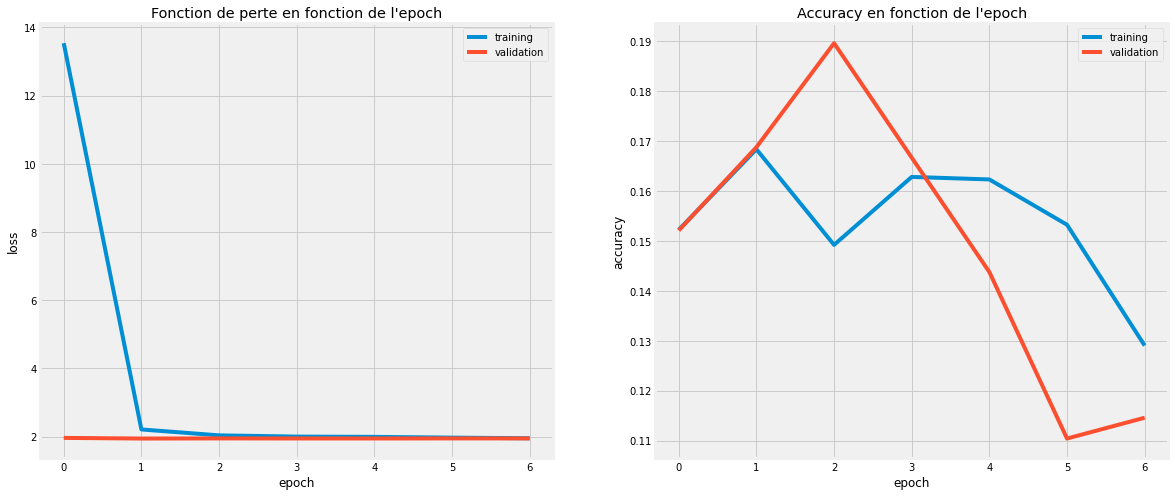

time: 250 ms (started: 2022-02-10 13:18:32 +01:00)


In [104]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(range(len(training_history_incep_1.history['loss'])), training_history_incep_1.history['loss'], label = "training")
plt.plot(range(len(training_history_incep_1.history['val_loss'])), training_history_incep_1.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Fonction de perte en fonction de l'epoch")
plt.legend()

plt.subplot(122)
plt.plot(range(len(training_history_incep_1.history['accuracy'])), training_history_incep_1.history['accuracy'], label = "training")
plt.plot(range(len(training_history_incep_1.history['val_accuracy'])), training_history_incep_1.history['val_accuracy'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de l'epoch")
plt.legend();

# Modele inceptionV3 - 2

In [87]:
incep_2 = InceptionV3(include_top=False, input_shape=(320, 240, 3))
for layer in incep_2.layers:
    layer.trainable = False

time: 3.08 s (started: 2022-02-10 12:36:24 +01:00)


In [95]:
model_incep_2 = Sequential()
model_incep_2.add(incep)
model_incep_2.add(GlobalAveragePooling2D())
model_incep_2.add(Dense(units = 1024, activation = 'relu'))
model_incep_2.add(Dropout(0.3))
model_incep_2.add(Dense(units = 512, activation = 'relu'))
model_incep_2.add(Dropout(0.5))
model_incep_2.add(Dense(units = 7, activation = 'softmax'))

model_incep.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d_8   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               524800    
                                                                 
 dropout_13 (Dropout)        (None, 512)               0         
                                                      

In [96]:

batch_size = 32
lr = 0.001
model_incep_2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
K.set_value(model_incep_2.optimizer.learning_rate, lr) #set learning rate 



training_history_incep = model_incep_2.fit(train_generator,
                                         epochs=10,
                                         steps_per_epoch = len(df_train)//batch_size,
                                          validation_data = test_generator,
                                           
                                         validation_steps = len(df_test)//batch_size,
                                         class_weight=class_weights,
                                          callbacks=[
                                                     early_stopping,reduce_learning_rate, #KERAS
                                                      ]
                                        )

Epoch 1/10
125/125 [==============================] - 223s 2s/step - loss: 7.3591 - accuracy: 0.1475 - val_loss: 1.9468 - val_accuracy: 0.1734 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 217s 2s/step - loss: 1.9990 - accuracy: 0.1392 - val_loss: 1.9460 - val_accuracy: 0.1724 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 217s 2s/step - loss: 1.9721 - accuracy: 0.1503 - val_loss: 1.9461 - val_accuracy: 0.1321 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 1.9618 - accuracy: 0.1295
Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
125/125 [==============================] - 215s 2s/step - loss: 1.9618 - accuracy: 0.1295 - val_loss: 1.9459 - val_accuracy: 0.1331 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 216s 2s/step - loss: 1.9507 - accuracy: 0.1415 - val_loss: 1.9459 - val_accuracy: 0.1341 - lr: 1.0000e-05
Epoch 00005: early stopping
time: 18min 8s (starte

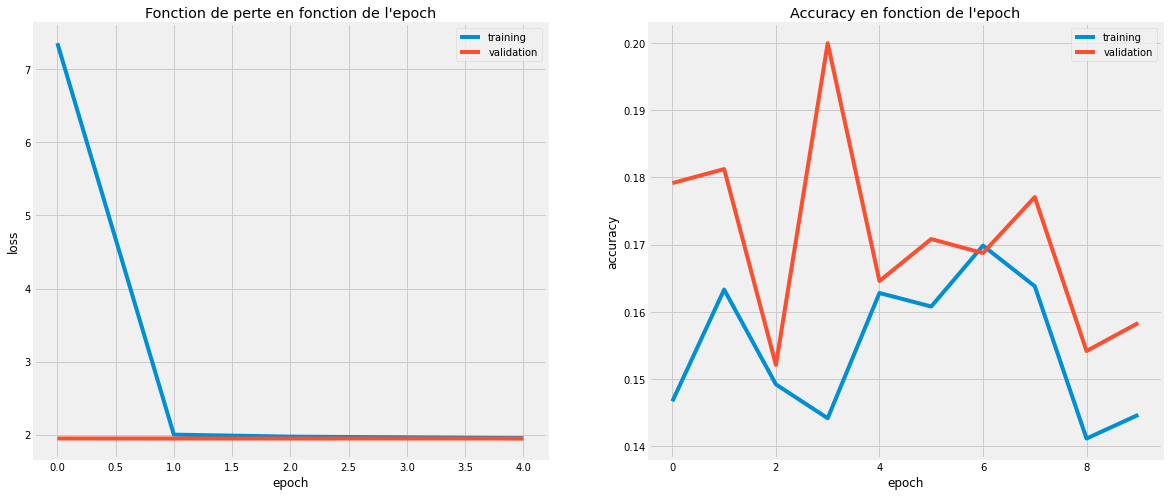

time: 203 ms (started: 2022-02-10 13:01:39 +01:00)


In [98]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(range(len(training_history_incep.history['loss'])), training_history_incep.history['loss'], label = "training")
plt.plot(range(len(training_history_incep.history['val_loss'])), training_history_incep.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Fonction de perte en fonction de l'epoch")
plt.legend()

plt.subplot(122)
plt.plot(range(len(training_history_model.history['accuracy'])), training_history_model.history['accuracy'], label = "training")
plt.plot(range(len(training_history_model.history['val_accuracy'])), training_history_model.history['val_accuracy'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de l'epoch")
plt.legend();

# Autre modèle

In [74]:
from tensorflow.keras.applications import MobileNetV3Small
base_model=MobileNetV3Small(weights='imagenet',include_top=False)
for layer in base_model.layers: #freeze the base_model layers
    layer.trainable = False
model3=Sequential()
model3.add(base_model)
model3.add(GlobalAveragePooling2D()) 
model3.add(Dense(units = 1024, activation = 'relu'))
model3.add(Dropout(0.3))
model3.add(Dense(units = 512, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(units = 7, activation = 'softmax'))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_5   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dropout_7 (Dropout)         (None, 512)              

In [75]:
model3.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
K.set_value(model_incep.optimizer.learning_rate, lr) #set learning rate 

batch_size = 64
lr = 0.001

training_history_model3 = model3.fit(train_generator,
                                         epochs=10,
                                         steps_per_epoch = len(df_train)//batch_size,
                                          validation_data = test_generator,
                                         validation_steps = len(df_test)//batch_size,
                                         class_weight=class_weights,
                                          #callbacks=[
                                          #           early_stopping,reduce_learning_rate, #KERAS
                                          #            ]
                                    )

Epoch 1/10
62/62 [==============================] - 33s 504ms/step - loss: 1.6898 - accuracy: 0.3826 - val_loss: 1.3874 - val_accuracy: 0.5000
Epoch 2/10
62/62 [==============================] - 30s 479ms/step - loss: 1.3480 - accuracy: 0.5101 - val_loss: 1.3417 - val_accuracy: 0.5229
Epoch 3/10
62/62 [==============================] - 30s 479ms/step - loss: 1.1812 - accuracy: 0.5822 - val_loss: 1.3640 - val_accuracy: 0.4938
Epoch 4/10
62/62 [==============================] - 30s 479ms/step - loss: 1.1189 - accuracy: 0.5968 - val_loss: 1.3396 - val_accuracy: 0.5042
Epoch 5/10
62/62 [==============================] - 30s 491ms/step - loss: 0.9692 - accuracy: 0.6583 - val_loss: 1.4013 - val_accuracy: 0.5063
Epoch 6/10
62/62 [==============================] - 31s 492ms/step - loss: 0.8871 - accuracy: 0.6820 - val_loss: 1.2989 - val_accuracy: 0.5562
Epoch 7/10
62/62 [==============================] - 32s 523ms/step - loss: 0.8255 - accuracy: 0.7092 - val_loss: 1.4156 - val_accuracy: 0.5458

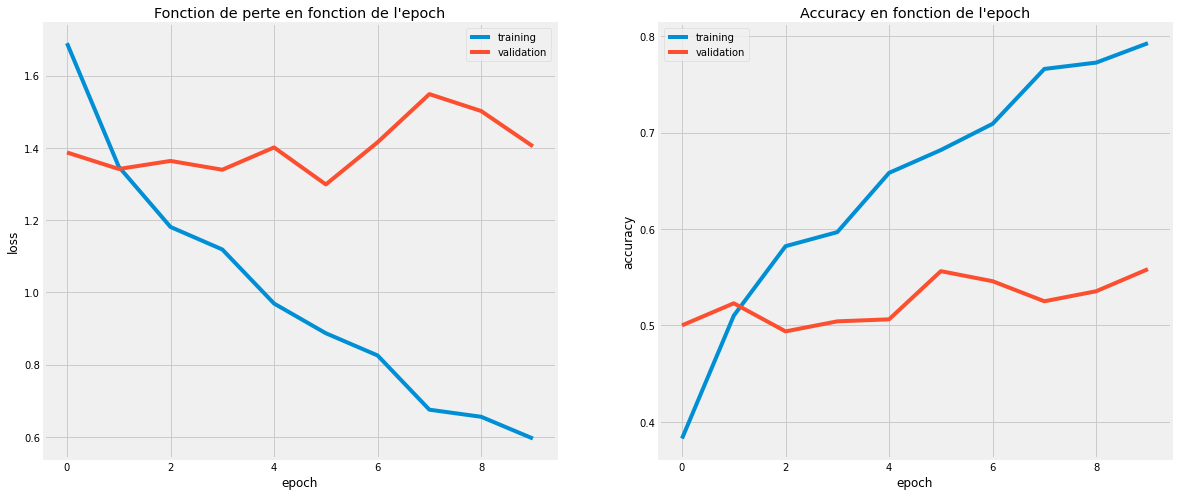

time: 172 ms (started: 2022-02-10 12:05:02 +01:00)


In [76]:
plt.figure(figsize=(18,8))
plt.subplot(121)
plt.plot(range(len(training_history_model3.history['loss'])), training_history_model3.history['loss'], label = "training")
plt.plot(range(len(training_history_model3.history['val_loss'])), training_history_model3.history['val_loss'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Fonction de perte en fonction de l'epoch")
plt.legend()

plt.subplot(122)
plt.plot(range(len(training_history_incep.history['accuracy'])), training_history_model3.history['accuracy'], label = "training")
plt.plot(range(len(training_history_model3.history['val_accuracy'])), training_history_model3.history['val_accuracy'], label = "validation")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy en fonction de l'epoch")
plt.legend();